# Step 2B: Model Testing

This notebook examines the model created in the `2b_model_building` notebook.

Using the `2a_feature_engineering` Jupyter notebook, this notebook creates a new test data set and scores the observations using the machine learning model (a decision tree classifier or a random forest classifier) created in the `2b_model_building` to predict when different components within the test machine population will fail. Then using the known labels from the existing data, we calculate a set of evaluation metrics to understand how the model may perform when used in production settings.  

**Note:** This notebook will take about 2-4 minutes to execute all cells, depending on the compute configuration you have setup.

In [2]:
# import the libraries
# For some data handling
import numpy as np
import pandas as pd

from collections import OrderedDict

import pyspark.sql.functions as F
from pyspark.ml import PipelineModel
# for creating pipelines and model
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt

# This is the final feature data file.
testing_table = 'testing_data'
model_type = 'RandomForest' # Use 'DecisionTree' or 'GBTClassifier' or 'RandomForest'

In [3]:
dbutils.widgets.removeAll()
dbutils.widgets.text("Testing_table",testing_table)
dbutils.widgets.text("Model", model_type)

dbutils.widgets.text("start_date", '2015-11-30')

dbutils.widgets.text("to_date", '2016-02-01')

# Prepare the Training/Testing data

A fundamental practice in machine learning is to calibrate and test your model parameters on data that has not been used to train the model. Evaluation of the model requires splitting the available data into a training portion, a calibration portion and an evaluation portion. Typically, 80% of data is used to train the model and 10% each to calibrate any parameter selection and evaluate your model.

In general random splitting can be used, but since time series data have an inherent correlation between observations. For predictive maintenance problems, a time-dependent spliting strategy is often a better approach to estimate performance. For a time-dependent split, a single point in time is chosen, the model is trained on examples up to that point in time, and validated on the examples after that point. This simulates training on current data and score data collected in the future data after the splitting point is not known. However, care must be taken on labels near the split point. In this case, feature records within 7 days of the split point can not be labeled as a failure, since that is unobserved data. 

In the following code blocks, we create a data set to test the model.

In [6]:
#print(spark.catalog.listDatabases())
spark.catalog.setCurrentDatabase("default")
exists = False
for tbl in spark.catalog.listTables():
  if tbl.name == dbutils.widgets.get("Testing_table"):
    exists = True
    break

In [7]:
if not exists:
  dbutils.notebook.run("2a_feature_engineering", 600, {"features_table": dbutils.widgets.get("Testing_table"), 
                                                       "start_date": dbutils.widgets.get("start_date"), 
                                                       "to_date": dbutils.widgets.get("to_date")})

# Classification models

A particular problem in predictive maintenance is machine failures are usually rare occurrences compared to normal operation. This is fortunate for the business as maintenance and saftey issues are few, but causes an imbalance in the label distribution. This imbalance leads to poor performance as algorithms tend to classify majority class examples at the expense of minority class, since the total misclassification error is much improved when majority class is labeled correctly. This causes low recall or precision rates, although accuracy can be high. It becomes a larger problem when the cost of false alarms is very high. To help with this problem, sampling techniques such as oversampling of the minority examples can be used. These methods are not covered in this notebook. Because of this, it is also important to look at evaluation metrics other than accuracy alone.

We will build and compare two different classification model approaches:

 - **Decision Tree Classifier**: Decision trees and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

 - **Random Forest Classifier**: A random forest is an ensemble of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.

The next code block loads the model.

In [9]:
model_pipeline = PipelineModel.load("dbfs:/storage/models/" + dbutils.widgets.get("Model") + ".pqt")

print("Model loaded")
model_pipeline

Model loaded
 Out[ 5 ]: PipelineModel_cce1b33cb94c

To evaluate this model, we predict the component failures over the test data set. Since the test set has been created from data the model has not been seen before, it simulates future data. The evaluation then can be generalize to how the model could perform when operationalized and used to score new data.

In [11]:
test_data = spark.table(dbutils.widgets.get("Testing_table"))

# define list of input columns for downstream modeling

# We'll use the known label, and key variables.
label_var = ['label_e']
key_cols =['machineID','dt_truncated']

# Then get the remaing feature names from the data
input_features = test_data.columns

# We'll use the known label, key variables and 
# a few extra columns we won't need.
remove_names = label_var + key_cols + ['failure','model_encoded','model' ]

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_names)]

#input_features
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')

# assemble features
test_data = va.transform(test_data).select('machineID','dt_truncated','label_e','features').cache()

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(test_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label_e", outputCol="indexedLabel").fit(test_data)

testing = test_data

print(testing.count())

# make predictions. The Pipeline does all the same operations on the test data
predictions = model_pipeline.transform(testing)

# Create the confusion matrix for the multiclass prediction results
# This result assumes a decision boundary of p = 0.5
conf_table = predictions.stat.crosstab('indexedLabel', 'prediction')
confuse = conf_table.toPandas()
confuse.head()

66034
 Out[ 6 ]: 
 indexedLabel_prediction 0.0 1.0 2.0 3.0 4.0
0 0.0 61923 25 17 34 11
1 1.0 1095 394 1 1 0
2 2.0 736 2 256 2 0
3 3.0 595 0 0 280 0
4 4.0 483 4 2 1 172

The confusion matrix lists each true component failure in rows and the predicted value in columns. Labels numbered 0.0 corresponds to no component failures. Labels numbered 1.0 through 4.0 correspond to failures in one of the four components in the machine. As an example, the third number in the top row indicates how many days we predicted component 2 would fail, when no components actually did fail. The second number in the second row, indicates how many days we correctly predicted a component 1 failure within the next 7 days.

We read the confusion matrix numbers along the diagonal as correctly classifying the component failures. Numbers above the diagonal indicate the model incorrectly predicting a failure when non occured, and those below indicate incorrectly predicting a non-failure for the row indicated component failure.

When evaluating classification models, it is convenient to reduce the results in the confusion matrix into a single performance statistic. However, depending on the problem space, it is impossible to always use the same statistic in this evaluation. Below, we calculate four such statistics.

- **Accuracy**: reports how often we correctly predicted the labeled data. Unfortunatly, when there is a class imbalance (a large number of one of the labels relative to others), this measure is biased towards the largest class. In this case non-failure days.

Because of the class imbalance inherint in predictive maintenance problems, it is better to look at the remaining statistics instead. Here positive predictions indicate a failure.

- **Precision**: Precision is a measure of how well the model classifies the truely positive samples. Precision depends on falsely classifying negative days as positive.

- **Recall**: Recall is a measure of how well the model can find the positive samples. Recall depends on falsely classifying positive days as negative.

- **F1**: F1 considers both the precision and the recall. F1 score is the harmonic average of precision and recall. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

These metrics make the most sense for binary classifiers, though they are still useful for comparision in our multiclass setting. Below we calculate these evaluation statistics for the selected classifier.

In [13]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['1.0'][1]+confuse['2.0'][2]+confuse['3.0'][3]+confuse['4.0'][4]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['1.0', '2.0','3.0','4.0']])) - tp

# True negatives 
tn = confuse['0.0'][0]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['0.0']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['0.0','1.0', '2.0','3.0','4.0']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))
print("")

Accuracy = 0.954433
Precision = 0.916805
Recall = 0.274744
F1 = 0.422789

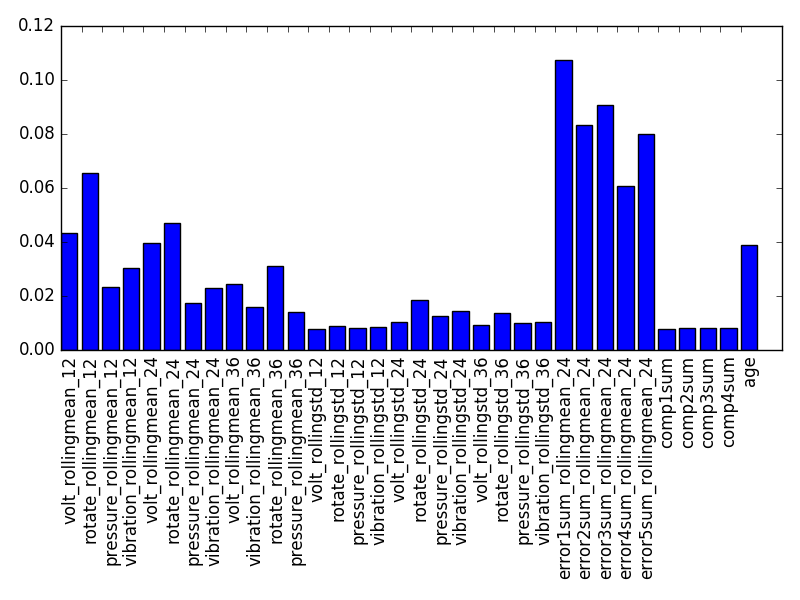

In [14]:
importances = model_pipeline.stages[2]
x = range(34)

fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.bar(x, list(importances.featureImportances.values))
plt.xticks(x)
plt.xlabel('')
ax.set_xticklabels(input_features, rotation = 90, ha="left")
#plt.gcf().subplots_adjust(bottom=0.50)
plt.tight_layout()
display()
# input_features

Remember that this is a simulated data set. We would expect a model built on real world data to behave very differently. The accuracy may still be close to one, but the precision and recall numbers would be much lower.

# Conclusion

The next step is to build the batch scoreing operations. The `3b_model_scoring` notebook takes parameters to define the data to be scored, and using the model created here, calulates the probability of component failure in the machine population specified.